In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import tree
from sklearn import svm, datasets
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, auc, roc_curve, roc_auc_score

### Gradient boosting

You may recall that we last encountered gradients when discussing the gradient descent algorithm in the context of fitting linear regression models.  For a particular regression model with n parameters, an n+1 dimensional space existed defined by all the parameters plus the cost/loss function to minimize.  The combination of parameters and loss function define a surface within the space.  The regression model is fitted by moving down the steepest 'downhill' gradient until we reach the lowest point of the surface, where all possible gradients are 'uphill.'  The final model is made up of the parameter estimates that define that location on the surface.

Throughout all iterations of the gradient descent algorithm for linear regression, one thing remains constant: The underlying data used to estimate the parameters and calculate the loss function never changes.  In gradient boosting, however, the underlying data do change.  

Each time we run a decision tree, we extract the residuals.  Then we run a new decision tree, using those residuals as the outcome to be predicted.  After reaching a stopping point, we add together the predicted values from all of the decision trees to create the final gradient boosted prediction.

Gradient boosting can work on any combination of loss function and model type, as long as we can calculate the derivatives of the loss function with respect to the model parameters.  Most often, however, gradient boosting uses decision trees, and minimizes either the  residual (regression trees) or the negative log-likelihood (classification trees).  

Let’s go through a simple regression example using Decision Trees as the base predictors (of course Gradient Boosting also works great with regression tasks). This is called Gradient Tree Boosting, or Gradient Boosted Regression Trees. First, let’s fit a `DecisionTreeRegressor` to the training set.

# Gradient Boosted Regression Trees Model Steps

### Create a data set

In [2]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

### First fit a DecisionTreeRegressor to the training set:

In [3]:
from sklearn.tree import DecisionTreeRegressor

# First regressor predictor: First Decision Tree Model
tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

### Now train a second DecisionTreeRegressor on the residual errors made by the first predictor:

In [4]:
# Residual errors from first predictor 
y2 = y - tree_reg1.predict(X)

# Second regressor predictor: Second Decision Tree Model
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

### Then we train a third regressor on the residual errors made by the second predictor:

In [5]:
# Residual errors from second predictor 
y3 = y2 - tree_reg2.predict(X)

# Third regressor predictor: Third Decision Tree Model
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

### Now we have an ensemble containing three trees. It can make predictions on a new instance simply by adding up the predictions of all the trees:

In [6]:
X_new = np.array([[0.8]])

In [7]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [8]:
y_pred

array([0.75026781])

The figure below represents the predictions of these three trees in the left column, and the ensemble’s predictions in the right column. In the first row, the ensemble has just one tree, so its predictions are exactly the same as the first tree’s predictions. In the second row, a new tree is trained on the residual errors of the first tree. On the right you can see that the ensemble’s predictions are equal to the sum of the predictions of the first two trees. Similarly, in the third row another tree is trained on the residual errors of the second tree. You can see that the ensemble’s predictions gradually get better as trees are added to the ensemble.

**<font color='teal'>Run the below cell to develop a visual representation.</font>**

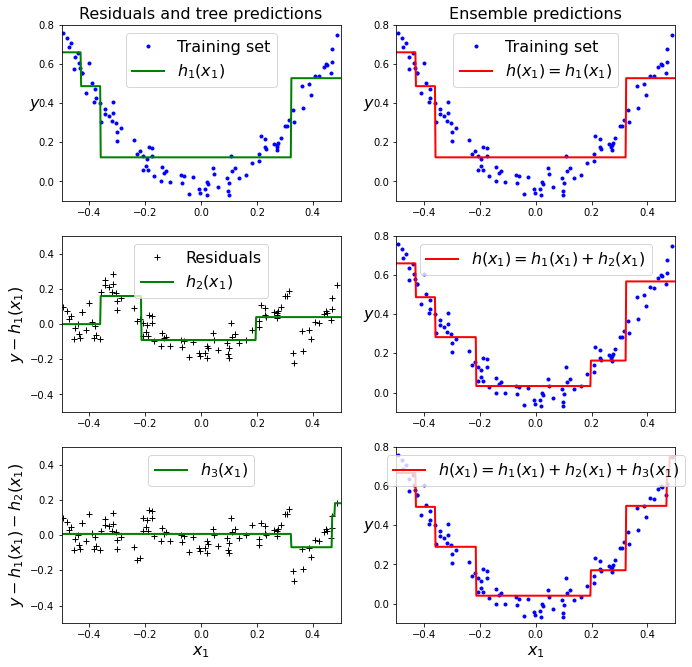

In [9]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

#save_fig("gradient_boosting_plot")
plt.show()

Now that you have solid understanding of Gradient Boosting in the regression scenario, let's apply the same algorithm to a classification problem. Specifically, the Titanic dataset and predicting survival.

**<font color='teal'>Use pandas read csv to load in the Titantic data set into a dataframe called df.</font>**

Hint: in this case you can use [dropna()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html) to just throw away any incomplete rows. For the purpose of this exercise we will disregard them but obviously in the real world you need to be much more careful and decide how to handle incomplete observations. 

In [10]:
# Load titanic data from local folder, we can also get the data using df = sns.load_dataset("titanic")
df = pd.read_csv("titanic.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


**<font color='teal'>Print the levels of the categorical data using 'select_dtypes'. </font>**

In [12]:
# Select columns with categorical data (Dtype = object) in a dataframe dfo
dfo=df.select_dtypes(include=['object'])
dfo.head(3)

,Name,Sex,Ticket,Cabin,Embarked
0,"Braund, Mr. Owen Harris",male,A/5 21171,NaN,S
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C85,C
2,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,NaN,S


In [13]:
# Print the levels of the categorical data variables in a dataframe cv (catergorical variables)
cv = pd.DataFrame(dfo.nunique()).reset_index()
cv.columns = ['VarName', 'LevelsCount']
cv.head()

,VarName,LevelsCount
0,Name,891
1,Sex,2
2,Ticket,681
3,Cabin,147
4,Embarked,3


**<font color='teal'>Create dummy features for the categorical features and add those to the 'df' dataframe. Make sure to also remove the original categorical columns from the dataframe.</font>**

In [14]:
df = pd.DataFrame(df.drop(dfo.columns,axis =1)).merge(pd.get_dummies(dfo.drop(['Name','Cabin','Ticket'],axis =1)),left_index=True,right_index=True).drop(['PassengerId'],axis =1)
print(df.shape)
df.head()

(891, 11)


,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,1,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,1,0,0,1


**<font color='teal'>Print the null values for each column in the dataframe.</font>**

In [15]:
df.isnull().sum()

Survived        0
Pclass          0
Age           177
SibSp           0
Parch           0
Fare            0
Sex_female      0
Sex_male        0
Embarked_C      0
Embarked_Q      0
Embarked_S      0
dtype: int64

In [16]:
# Drop the Age column
df.drop(columns=['Age'], inplace=True)
df.columns

Index(['Survived', 'Pclass', 'SibSp', 'Parch', 'Fare', 'Sex_female',
       'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

**<font color='teal'>Create the X and y matrices from the dataframe, where y = df.Survived </font>**

In [17]:
X = df.drop(columns=['Survived'], axis=1)
y = df.Survived

In [18]:
X.head(2)

,Pclass,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,1,0,7.2500,0,1,0,0,1
1,1,1,0,71.2833,1,0,1,0,0


**<font color='teal'>Apply the standard scaler to the X matrix.</font>**

In [19]:
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

**<font color='teal'>Split the X_scaled and y into 75/25 training and testing data subsets..</font>**

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=1)

**<font color='teal'>Run the cell below to test multiple learning rates in your gradient boosting classifier.</font>**

In [21]:
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=20, learning_rate = learning_rate, max_features=2, max_depth = 2, random_state = 0)
    gb.fit(X_train, y_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(X_test, y_test)))
    print()

Learning rate:  0.05
Accuracy score (training): 0.798
Accuracy score (validation): 0.749

Learning rate:  0.1
Accuracy score (training): 0.825
Accuracy score (validation): 0.762

Learning rate:  0.25
Accuracy score (training): 0.826
Accuracy score (validation): 0.789

Learning rate:  0.5
Accuracy score (training): 0.831
Accuracy score (validation): 0.771

Learning rate:  0.75
Accuracy score (training): 0.837
Accuracy score (validation): 0.776

Learning rate:  1
Accuracy score (training): 0.832
Accuracy score (validation): 0.789



**<font color='teal'>Apply the best learning rate to the model fit and predict on the testing set. Print out the confusion matrix and the classification report to review the model performance.</font>**

In [122]:
# From the multiple learning rates in the gradient boosting classifier results we conclude that 1 as the best learning rate
# It provides the best Accuracy score for the validation set: 0.789, followed by a great score for the training set: 0.832

learning_rate = 1

# Apply the best learning rate to the model fit and predict on the testing set
gb = GradientBoostingClassifier(n_estimators=20, learning_rate = learning_rate, max_features=2, max_depth = 2, random_state = 0)
GB_model = gb.fit(X_train, y_train)
y_pred = GB_model.predict(X_test)

In [23]:
# Model performance: accuracy and f1 scores
ac = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print('Gradient Boosting: Accuracy = %.3f' % (ac))
print('Gradient Boosting: f1-score = %.3f' % (f1))

Gradient Boosting: Accuracy = 0.789
Gradient Boosting: f1-score = 0.782


In [24]:
# Print out the classification report to review the model performance
print("\n Classification Report ")
print(classification_report(y_test, y_pred))


 Classification Report 
              precision    recall  f1-score   support

           0       0.76      0.92      0.83       128
           1       0.85      0.61      0.71        95

    accuracy                           0.79       223
   macro avg       0.81      0.77      0.77       223
weighted avg       0.80      0.79      0.78       223



**<font color='teal'>Compute, print out, and plot the confusion matrix.</font>**

**The confusion matrix** evaluates the quality of the output of a classifier on the data set. The diagonal elements represent the number of points for which the predicted label is equal to the true label, while off-diagonal elements are those that are mislabeled by the classifier. The higher the diagonal values of the confusion matrix the better, indicating many correct predictions.

In [113]:
# Compute and print out the confusion matrix 
print("Confusion matrix")
cm = confusion_matrix(y_test, y_pred)

pd.DataFrame(cm, columns=['Predicted died (class=0)', "Predicted Survived (class=1)"], index=['Actual died', 'Actual Survived'])

Confusion matrix


,Predicted died (class=0),Predicted Survived (class=1)
Actual died,118,10
Actual Survived,37,58


Any binary classifier classifies the results in terms of positive aka 1 or negative aka 0 class, hence the name. So the results that the classifier predicts to be positive and are actually positive are the True Positives, the results that were falsely classified as positive but are in fact negative are False Positives. True Negatives, yeah, you guessed it, are actual negative class predicted as negative and False Negatives are the falsely predicted negative but are in fact positive.

In [123]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(f'True Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')

True Positives: 58
False Positives: 10
True Negatives: 118
False Negatives: 37


Confusion matrix, without normalization
[[118  10]
 [ 37  58]]
Normalized confusion matrix
[[0.92 0.08]
 [0.39 0.61]]


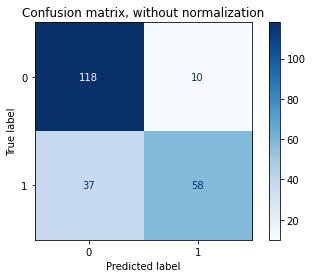

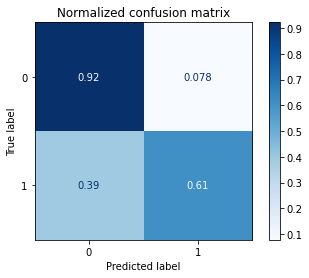

In [26]:
# Plot non-normalized and normalized confusion matrix

from sklearn.metrics import plot_confusion_matrix
class_names=['0','1']

titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

# gb: gradient boosting classifier
# gb = GradientBoostingClassifier(n_estimators=20, learning_rate = learning_rate, max_features=2, max_depth = 2, random_state = 0)
classifier = gb.fit(X_train, y_train)

for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

**<font color='teal'>Calculate and plot the Receiver Operating Characteristic (ROC) for the model.</font>**

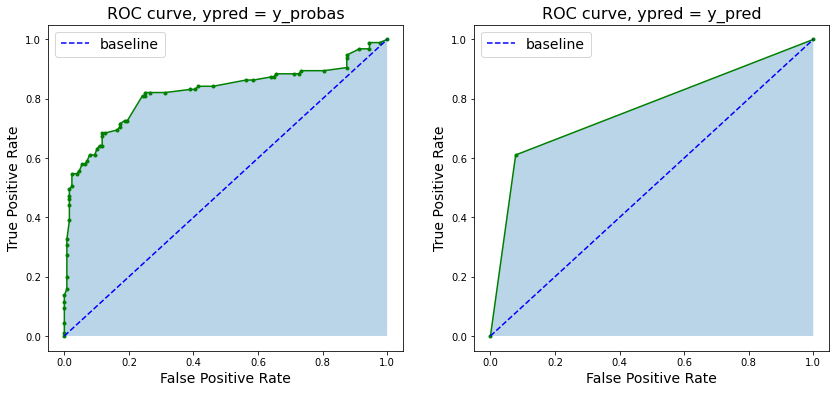

In [156]:
# ROC curve is often utilised as a visualisation plot to measure the performance of a binary classifier. 
# It’s not a metric of the model, per se, rather the graphical representation of the True Positive Rate 
# (TPR) versus False Positive rate (FPR) at various classification threshold from 0 to 1.
# It can also be thought of as the power of Type I Error (False Positives) decision rule function, where:
# The power of a binary hypothesis test is the probability that the test rejects the null hypothesis (H0) 
# when a specific alternative hypothesis (H1) is true. Power = p(rejectH) / H1 is true)
# Ref: https://medium.com/@kunanba/what-is-roc-auc-and-how-to-visualize-it-in-python-f35708206663

# The roc_curve(ytest, ypred) function requires a test and model predicted sets

y_probas = GB_model.predict_proba(X_test)[:, 1]
# Since *.predict_proba* estimates probabilities for negative and positive classes,
# we need to select the probabilities for the positive class only

# Compute ROC with model predicted set = y_probas
fpr_gb, tpr_gb, thresholds_gb = roc_curve(y_test, y_probas) #y_test=true binary labels, y_scores = target scores, prob estimates, or confidence va

# Compute ROC with model predicted set = y_pred 
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Define an ROC plot function
def ROC_plot(fpr, tpr, ypredName, ax):
    ax.plot(fpr, tpr, color="green", marker='.')
    # Add dashed line with a slope of 1
    ax.plot([0, 1], [0, 1], color ='blue', linestyle = '--', label='baseline')
    # Fill AUC
    fillArea = True
    if fillArea == True:
        ax.fill_between(fpr, tpr, alpha=.3)
    # end fill AUC
    ax.set_xlabel('False Positive Rate', fontsize=14)
    ax.set_ylabel('True Positive Rate', fontsize=14)
    ax.set_title('ROC curve, ypred = {}'.format(ypredName), fontsize=16)
    ax.legend(fontsize=14)
    plt.grid()

# Plot ROC figures   
fig, ax = plt.subplots(1, 2, figsize=(14,6))
# Left figure
ROC_plot(fpr_gb, tpr_gb, 'y_probas', ax[0])
# Right figure
ROC_plot(fpr, tpr, 'y_pred', ax[1])

# The closer an ROC curve is to the upper left corner, the more efficient is the test.


**<font color='teal'>Calculate the Area-Under-Curve (AUC) from ROC.</font>**

In [131]:
print('''AUC assess the performance of the model. The closer the score to 1 the better the model distinguishes the clasess, 
if it’s closer to 0.5 then your model performs just as badly as the coin flip.''')

# fpr_gb, tpr_gb, _ = roc_curve(y_test, y_probas)

# auc(): computes area under the curve (auc) using the trapezoidal rule
roc_auc_gb = auc(fpr_gb, tpr_gb)
print("\nArea under ROC curve auc() = {:0.2f}".format(roc_auc_gb))

# roc_auc_score(): Computes auc from predicted scores = y_probas
roc_auc = roc_auc_score(y_test, y_probas)
print("Area under ROC curve roc_auc_score() = {:0.2f}".format(roc_auc))

print('\nroc_auc_score(): Computes auc with predicted scores = y_pred')
roc_auc2 = roc_auc_score(y_test, y_pred)
print("Area under ROC curve roc_auc_score() = {:0.2f}".format(roc_auc2))

AUC assess the performance of the model. The closer the score to 1 the better the model distinguishes the clasess, 
if it’s closer to 0.5 then your model performs just as badly as the coin flip.

Area under ROC curve auc() = 0.82
Area under ROC curve roc_auc_score() = 0.82

roc_auc_score(): Computes auc with predicted scores = y_pred
Area under ROC curve roc_auc_score() = 0.77


### Plot interactive ROC curve in Python
 
When using static plots, it’s hard to see the corresponding threshold value for different points across the curve. One option is to inspect the inputs dataframe we created. Another option is to create an interactive version of the plot so that we can see the FPR and TPR alongside the corresponding threshold value when we hover over the graph:

In [188]:
fpr_gb, tpr_gb, thresholds_gb = roc_curve(y_test, y_probas) 

# inputs = pd.DataFrame([thresholds_gb[:], fpr_gb[:], tpr_gb[:]], columns=columns)
d1 = pd.DataFrame(thresholds_gb[1:], columns=['threshold'])
d2 = pd.DataFrame(fpr_gb[1:], columns=['False Positive Rate'])
d3 = pd.DataFrame(tpr_gb[1:], columns=['True Positive Rate'])

inputs = pd.concat([d1, d2, d3], axis=1)
inputs.head(3)

,threshold,False Positive Rate,True Positive Rate
0,0.999852,0.0,0.010526
1,0.991411,0.0,0.042105
2,0.987257,0.0,0.094737


In [190]:
# Plot refe: https://www.kdnuggets.com/2021/07/roc-curve-explained.html
import plotly.express as px

def plot_interactive_roc_curve(df, fpr, tpr, thresholds):
    fig = px.area(
        data_frame = df,
        x=fpr, 
        y=tpr,
        hover_data=thresholds, 
        title='ROC Curve'
    )
    fig.update_layout(
        autosize=False,
        width=500,
        height=500,
        margin=dict(l=30, r=30, b=30, t=30, pad=4),
        title_x=.5, # Centre title
        hovermode = 'closest',
        xaxis=dict(hoverformat='.4f'),
        yaxis=dict(hoverformat='.4f')
    )
    hovertemplate = 'False Positive Rate=%{x}<br>True Positive Rate=%{y}<br>Threshold=%{customdata[0]:.4f}<extra></extra>'
    fig.update_traces(hovertemplate=hovertemplate)
    
    # Add dashed line with a slope of 1
    fig.add_shape(type='line', line=dict(dash='dash'), x0=0, x1=1, y0=0, y1=1)
    fig.show()
    

# Iterative plot

plot_interactive_roc_curve(df=inputs, 
                           fpr='False Positive Rate', 
                           tpr='True Positive Rate', 
                           thresholds=['threshold'])

# Review: Definitions and functions descriptions

### Receiver Operating Characteristic (ROC)

Receiver Operating Characteristic (ROC)curves are used in binary classification to study the output of a classifier.

ROC curves typically feature true positive rate on the Y axis, and false positive rate on the X axis. This means that the top left corner of the plot is the “ideal” point - a false positive rate of zero, and a true positive rate of one. This is not very realistic, but it does mean that a larger area under the curve (AUC) is usually better.

The “steepness” of ROC curves is also important, since it is ideal to maximize the true positive rate while minimizing the false positive rate.

ROC curves are typically used in binary classification to study the output of a classifier. In order to extend ROC curve and ROC area to multi-class or multi-label classification, it is necessary to binarize the output. One ROC curve can be drawn per label, but one can also draw a ROC curve by considering each element of the label indicator matrix as a binary prediction (micro-averaging). Ref: https://scikit-learn.org/0.15/auto_examples/plot_roc.html

**y_pred_prob** provides two columns for two classes, recall that when you are defining the target(0,1), 
there are two classes. Each row/datapoint would require a prediction on both 0 and 1. 
For example datapoint1 has 80% likelihood to belong to 0, and 20% belonging to 1. 
the output would be (0.8,0.2). you need to access prediciton[:,1] to get the second 
column if u want the prediction for 1. In general access prediction[:,k] 
if you want likelihood of the k th class.

In [81]:
y_pred_prob = GB_model.predict_proba(X_test) # y_pred_prob[0:2,] to see values from rows 0:2 
lr_probs = y_pred_prob[:,1]
lr_probs[0:5]

array([0.9 , 0.1 , 0.87, 0.73, 0.93])